In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

import gym
from gym import spaces
from gym.utils import seeding

In [2]:
class PID:
    def __init__(self, p=5, i=0.1, d=1):
        self.p = p
        self.i = i
        self.d = d
        self.i_value = 0

    def control(self, e, e_d):
        '''
        This function calculates control output
        @params:
            e: angular error
            e_d: angular velocity error
        '''
        self.i_value += e
        self.i_value = np.clip(self.i_value, -10000, 10000)
        return self.p * e + self.i * self.i_value + self.d * e_d

In [218]:
class Pendulum_PID_Env(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}
    '''
    only PID integrated environment
    '''
    def __init__(self):
        self.M = .5
        self.m = 0.2
        self.F0 = 0.1
        self.F1 = 0.1
        self.I = 0.006
        self.g = 9.8
        self.l = 0.3
        self.dt = 0.01

        high = np.array([np.pi/3, 10, np.pi/3, 10], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-30], dtype=np.float32), high=np.array([30], dtype=np.float32), shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi


    def step(self, PID1_param=[52.49,0,7.485], PID2_param=[129.7,0,11.75], target=[0,0]):
        '''
        @param:
            PID1_param, PID2_param: baseline parameters for 2 PIDs
        '''
        # initialization
        x, x_d, phi, phi_d = self.state  # retrieve info of the actuator link

        M = self.M
        m = self.m
        F0 = self.F0
        F1 = self.F1
        I = self.I
        g = self.g
        l = self.l
        kp1 = PID1_param[0]
        kd1 = PID1_param[2]
        kp2 = PID2_param[0]
        kd2 = PID2_param[2]
        
        p = I*(M+m)+M*m*l**2 # denominator for the A and B matrices
        A = (M+m)*m*g*l/p
        B = -F1*(M+m)/p
        C = F0*m*l/p
        D = -m*l/p
        E = -m*m*g*l*l/p
        F = F1*m*l/p
        G = -F0*(I+m*l*l)/p
        H = (I+m*l*l)/p
        
        
        e1 = target[0] - phi
        e2 = target[1] - phi_d

        x_d_r = ( kp1*e1+kd1*e2-A*phi-B*phi_d+E*D/H*phi+F*D/H*phi_d+G*D/H*x_d+D/H*kd2*x_d) / (C + D/H*kp2*self.dt)
        u = -E/H*phi -F/H*phi_d-G/H*x_d +(kp2*self.dt)*x_d_r/H -kd2/H*x_d


        # acceleration calculation
        
        phi_dd = A * phi + B * phi_d + C * x_d + D * u
        x_dd = E * phi + F * phi_d + G * x_d + H * u

        # semi-implicit euler
        for _ in range(1):
            x += self.dt * x_d / 1
            x_d += self.dt * x_dd / 1
            x = np.clip(x, -100, 100)
            x_d = np.clip(x_d, -100, 100)

            phi += self.dt * phi_d / 1
            phi_d += self.dt * phi_dd / 1
            phi_d = np.clip(phi_d, -100, 100)
            phi = self.normalize(phi)
        
            
            
        ############## cost ####################
        costs = self.normalize(phi) ** 2 + 0.1 * phi_d**2 + 0.00 * x**2 # + 0.001 * (u**2)

        # Output
        self.state = np.array([float(x), float(x_d), float(phi), float(phi_d)])

        return self._get_obs(), -float(costs), False, {'x_d_r':x_d_r}

    def reset(self):
        # always reset all to 0
        high = np.array([np.pi/2, 10, np.pi/2, 10], dtype=np.float32)
        self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([0, 0, 0.5, 0], dtype=np.float32)
        return self.state

    def _get_obs(self):
        # we can only observe the angle of the actuator
        x, x_d, phi, phi_d = self.state
        return np.array([x, x_d, phi, phi_d], dtype=np.float32)

In [726]:
M = 0.5
m = 0.2
F0 = 0.1
F1 = 0.1
I = 0.006
g = 9.8
l = 0.3
dt = 0.01

# M,m,F0,F1,J,g,l,dt = sympy.symbols("M m F0 F1 J g l dt")
e1,e2,e3,e4 = sympy.symbols("e1 e2 e3 e4")


p = I*(M+m)+M*m*l**2 # denominator for the A and B matrices
A = (M+m)*m*g*l/p
B = -F1*(M+m)/p
C = F0*m*l/p
D = -m*l/p
E = -m*m*g*l*l/p
F = F1*m*l/p
G = -F0*(I+m*l*l)/p
H = (I+m*l*l)/p

#p,A,B,C,D,E,F,G,H = sympy.symbols("p A B C D E F G H")


kp1 = 133.8
kd1 = 46.67
kp2 = 82.17
kd2 = 80.336

#kp1,kd1,kp2,kd2 = sympy.symbols("kp1 kd1 kp2 kd2")

x_d_r = ( kp1*e1+kd1*e2+A*e1+B*e2-E*D/H*e1-F*D/H*e2-G*D/H*e4-D/H*kd2*e4) / (C + D/H*kp2*dt)
# u = E/H*e1 +F/H*e2+G/H*e4 +(kp2*dt)*x_d_r/H +kd2/H*e4
u = E/H*e1 +F/H*e2+G/H*e4 +kp2*e3/H +kd2/H*e4

e2_d = A*e1+B*e2+C*e4-D*u
e4_d = -kp2*e3 -kd2*e4
x_d_r_d = ( kp1*e2+kd1*e2_d+A*e2+B*e2_d-E*D/H*e2-F*D/H*e2_d-G*D/H*e4_d-D/H*kd2*e4_d) / (C + D/H*kp2*dt)
e3_d = x_d_r_d * dt


j21 = sympy.diff(e2_d,e1)
j22 = sympy.diff(e2_d,e2)
j23 = sympy.diff(e2_d,e3)
j24 = sympy.diff(e2_d,e4)

j31 = sympy.diff(e3_d,e1)
j32 = sympy.diff(e3_d,e2)
j33 = sympy.diff(e3_d,e3)
j34 = sympy.diff(e3_d,e4)


In [727]:
JM = np.array([[0, 1, 0, 0],
              [j21,j22,j23,j24],
              [j31,j32,j33,j34],
              [0, 0, -kp2, -kd2]])

In [728]:
JM

array([[0, 1, 0, 0],
       [24.5000000000000, -4.16666666666667, 205.425000000000,
        200.840000000000],
       [-6.50952495962796, 0.117504337132962, 48.3490877860969,
        47.2699563877799],
       [0, 0, -82.17, -80.336]], dtype=object)

In [729]:
np.linalg.eig(np.array(JM, dtype=np.float))

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_26612/1419705488.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.linalg.eig(np.array(JM, dtype=np.float))


(array([-3.41497185e+01+0.j        , -1.00193017e+00+3.89940274j,
        -1.00193017e+00-3.89940274j,  3.36572953e-13+0.j        ]),
 array([[ 2.72414419e-02+0.j        , -5.88466646e-02+0.12316427j,
         -5.88466646e-02-0.12316427j,  1.50243626e-14+0.j        ],
        [-9.30287573e-01+0.j        , -4.21306841e-01-0.35286884j,
         -4.21306841e-01+0.35286884j, -3.59421868e-14+0.j        ],
        [-1.79245212e-01+0.j        , -5.72161622e-01-0.0281227j ,
         -5.72161622e-01+0.0281227j , -6.99082041e-01+0.j        ],
        [ 3.18895106e-01+0.j        ,  5.92614504e-01+0.j        ,
          5.92614504e-01-0.j        ,  7.15041467e-01+0.j        ]]))

In [585]:
phi_l = []
x_l = []
x_d_l = []
x_d_r_l = []

def episode_run(x1, x2, x3, x4):
    env = Pendulum_PID_Env()
    reward_episode = 0
    

    # Number of steps you run the agent for 
    num_steps = 500
    obs = env.reset()


    ################## simulation
    for step in range(num_steps):

        # apply the action
        obs, reward, done, info = env.step([x1, 0, x2], [x3, 0, x4])

        phi_l.append(obs[2])
        x_l.append(obs[0])
        x_d_r_l.append(info['x_d_r'])
        x_d_l.append(obs[1])
        
        reward_episode += reward
        
        
        # If the epsiode is up, then start another one
        if done:
            env.reset()

    # Close the env
    env.close()
    return reward_episode

In [602]:
episode_run(133.8,46.67,82.17,80.336)

-39.970909935274605

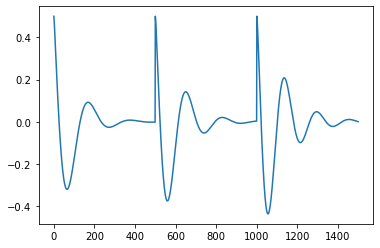

In [603]:
plt.plot(phi_l)

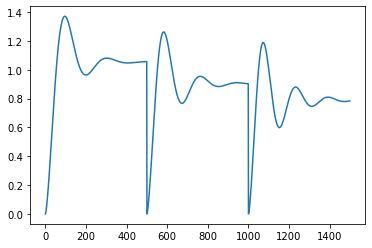

In [604]:
plt.plot(x_l)

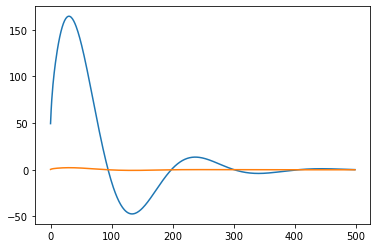

In [590]:
plt.plot(x_d_r_l)
plt.plot(x_d_l)

In [433]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x1': (0, 200), 'x2': (0, 50), \
           'x3': (0, 200), 'x4': (0, 50)}
optimizer = BayesianOptimization(
    f=episode_run,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------
|  3        | -25.15    |  79.35    |  26.94    |  83.84    |  34.26    |
|  5        | -18.55    |  83.46    |  27.93    |  28.08    |  9.905    |
|  6        | -16.81    |  160.1    |  48.41    |  62.68    |  34.62    |
|  9        | -14.09    |  191.6    |  26.66    |  138.4    |  15.78    |


KeyboardInterrupt: 

## Nonlinear

In [688]:
class Nonlinear_Pendulum_PID_Env(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}
    '''
    only PID integrated environment
    '''
    def __init__(self):
        self.M = .5
        self.m = 0.2
        self.F0 = 0.1
        self.F1 = 0.1
        self.J = 0.006
        self.g = 9.8
        self.l = 0.3
        self.dt = 0.01

        high = np.array([np.pi/3, 10, np.pi/3, 10], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-30], dtype=np.float32), high=np.array([30], dtype=np.float32), shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi


    def step(self, PID1_param=[52.49,0,7.485], PID2_param=[129.7,0,11.75], target=[0,0]):
        '''
        @param:
            PID1_param, PID2_param: baseline parameters for 2 PIDs
        '''
        # initialization
        x, x_d, phi, phi_d = self.state  # retrieve info of the actuator link

        M = self.M
        m = self.m
        F0 = self.F0
        F1 = self.F1
        J = self.J
        g = self.g
        l = self.l
        dt = self.dt
        
        kp1 = PID1_param[0]
        kd1 = PID1_param[2]
        kp2 = PID2_param[0]
        kd2 = PID2_param[2]
        
        p = (M+m)*(J+m*l**2) - m**2*l**2*np.cos(phi)**2 # denominator for the A and B matrices
        
        
        e1 = target[0] - phi
        e2 = target[1] - phi_d
        x_d_r = p*(kp1*e1+kd1*e2) + F1*(M+m)*phi_d + m*m*l*l*phi_d*phi_d*np.sin(phi)*np.cos(phi) - (M+m)*m*g*l*np.sin(phi) # - F0*m*l*np.cos(phi)*x_d
        x_d_r += m*l*np.cos(phi)/(J+m*l*l) * (-F1*m*l*phi_d*np.cos(phi) -(J+m*l*l)*m*l*phi_d**2*np.sin(phi) \
                                              +F0*(J+m*l*l)*x_d +m*m*g*l*l*np.sin(phi)*np.cos(phi))
        x_d_r -= m*l*np.cos(phi)*(p/(J+m*l*l)*kd2*x_d)
        x_d_r /= (F0*m*l*np.cos(phi)-p*m*l*np.cos(phi)*kp2*dt/(J+m*l*l))
        
        u = 1/(J+m*l*l) * (-F1*m*l*phi_d*np.cos(phi) -(J+m*l*l)*m*l*phi_d**2*np.sin(phi) \
                           +F0*(J+m*l*l)*x_d +m*m*g*l*l*np.sin(phi)*np.cos(phi))
        u += p/(J+m*l*l) * (kp2*dt*x_d_r - kd2*x_d)

        # acceleration calculation
        
        phi_dd = - F1*(M+m)*phi_d - m*m*l*l*phi_d*phi_d*np.sin(phi)*np.cos(phi) + (M+m)*m*g*l*np.sin(phi) + F0*m*l*np.cos(phi)*x_d - m*l*np.cos(phi)*u
        phi_dd /= p
        x_dd = F1*m*l*phi_d*np.cos(phi) +(J+m*l*l)*m*l*phi_d**2*np.sin(phi) -F0*(J+m*l*l)*x_d -m*m*g*l*l*np.sin(phi)*np.cos(phi) +(J+m*l*l)*u
        x_dd /= p

        # semi-implicit euler
        for _ in range(10):
            x += self.dt * x_d / 10
            x_d += self.dt * x_dd / 10
            x = np.clip(x, -100, 100)
            x_d = np.clip(x_d, -100, 100)

            phi += self.dt * phi_d / 10
            phi_d += self.dt * phi_dd / 10
            phi_d = np.clip(phi_d, -100, 100)
            phi = self.normalize(phi)
        
            
            
        ############## cost ####################
        costs = self.normalize(phi) ** 2 + 0.1 * phi_d**2 + 0.00 * x**2 # + 0.001 * (u**2)

        # Output
        self.state = np.array([float(x), float(x_d), float(phi), float(phi_d)])

        return self._get_obs(), -float(costs), False, {'x_d_r':x_d_r, 'u':u}

    def reset(self):
        # always reset all to 0
        high = np.array([np.pi/2, 10, np.pi/2, 10], dtype=np.float32)
        self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([0, 0, 1, 0], dtype=np.float32)
        return self.state

    def _get_obs(self):
        # we can only observe the angle of the actuator
        x, x_d, phi, phi_d = self.state
        return np.array([x, x_d, phi, phi_d], dtype=np.float32)

In [689]:
phi_l = []
x_l = []
x_d_l = []
x_d_r_l = []
u_l = []

def episode_run(x1, x2, x3, x4):
    env = Nonlinear_Pendulum_PID_Env()
    reward_episode = 0
    

    # Number of steps you run the agent for 
    num_steps = 500
    obs = env.reset()


    ################## simulation
    for step in range(num_steps):

        # apply the action
        obs, reward, done, info = env.step([x1, 0, x2], [x3, 0, x4])

        phi_l.append(obs[2])
        x_l.append(obs[0])
        x_d_r_l.append(info['x_d_r'])
        x_d_l.append(obs[1])
        u_l.append(info['u'])
        
        reward_episode += reward
        
        
        # If the epsiode is up, then start another one
        if done:
            env.reset()

    # Close the env
    env.close()
    return reward_episode

In [662]:
episode_run(229.6,58.69,235.7,179.9)

-0.6413155751696502

In [663]:
episode_run(251.9,84.07,301.1,26.61)

-0.32948600731821653

In [664]:
episode_run(147.4,42.98,112.6,75.7011)

-0.8107797601950418

In [690]:
episode_run(133.8,46.67,82.17,80.336)

-179.8584378168846

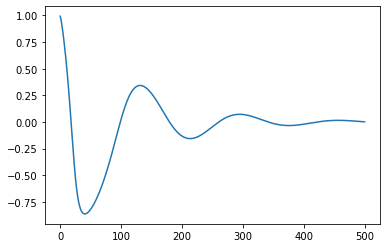

In [691]:
plt.plot(phi_l)

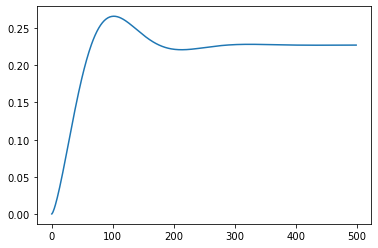

In [656]:
plt.plot(x_l)

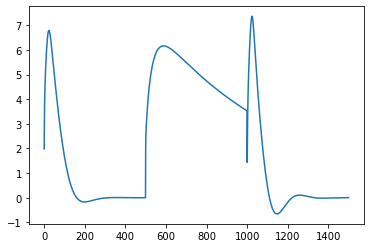

In [635]:
plt.plot(x_d_l)
# plt.plot(x_d_r_l)

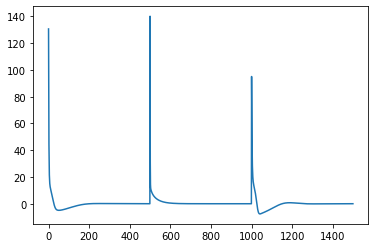

In [636]:
plt.plot(u_l)

In [371]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x1': (0, 200), 'x2': (0, 50), \
           'x3': (0, 200), 'x4': (0, 50)}
optimizer = BayesianOptimization(
    f=episode_run,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------
|  3        | -25.15    |  79.35    |  26.94    |  83.84    |  34.26    |
|  5        | -18.55    |  83.46    |  27.93    |  28.08    |  9.905    |
|  6        | -16.81    |  160.1    |  48.41    |  62.68    |  34.62    |
|  9        | -14.09    |  191.6    |  26.66    |  138.4    |  15.78    |
|  14       | -9.803    |  42.33    |  13.28    |  98.31    |  2.668    |
|  30       | -8.609    |  150.8    |  46.15    |  142.3    |  6.214    |
|  82       | -8.412    |  147.4    |  42.98    |  112.6    |  0.7011   |
|  133      | -8.3      |  150.7    |  50.0     |  68.09    |  0.0      |


## Jacobian

In [731]:
import sympy
e1, e2, e3, e4 = sympy.symbols("e1 e2 e3 e4")
M,m,F0,F1,J,g,l,dt = sympy.symbols("M m F0 F1 J g l dt")

M = .5
m = 0.2
F0 = 0.1
F1 = 0.1
J = 0.006
g = 9.8
l = 0.3
dt = 0.01

kp1 = 147.4
kd1 = 42.98
kp2 = 112.6
kd2 = 75.016

'''kp1 = 133.8
kd1 = 46.67
kp2 = 82.17
kd2 = 80.336'''

p = (M+m)*(J+m*l**2) - m**2*l**2*sympy.cos(e1)**2
p_d = 2*m*m*l*l*sympy.cos(e1)*sympy.sin(e1)*e2

A = p*(kp1*e1+kd1*e2) - F1*(M+m)*e2 + (M+m)*m*g*l*sympy.sin(e1)
A += m*l*sympy.cos(e1)/(J+m*l*l) * (F1*m*l*e2*sympy.cos(e1) -F0*(J+m*l*l)*e4 -m*m*g*l*l*sympy.sin(e1)*sympy.cos(e1))
A += m*l*sympy.cos(e1)*(p/(J+m*l*l)*kd2*e4)

B = F0*m*l*sympy.cos(e1)-p*m*l*sympy.cos(e1)*kp2*dt/(J+m*l*l)


u = 1/(J+m*l*l) * (F1*m*l*e2*sympy.cos(e1) +(J+m*l*l)*m*l*e2*e2*sympy.sin(e1) \
                   -F0*(J+m*l*l)*e4 \
                   -m*m*g*l*l*sympy.sin(e1)*sympy.cos(e1) \
                   +p*kp2*e3 \
                   +p*kd2*e4 )

e1_d = e2
e2_d =  -F1/p*(M+m)*e2 -m*m*l*l/p*e2*e2*sympy.sin(e1)*sympy.cos(e1) +F0*m*l/p*sympy.cos(e1)*e4 +(M+m)*m*g*l/p*sympy.sin(e1) +m*l/p*sympy.cos(e1)*u
e4_d = -kp2*e3-kd2*e4



A_d = p_d*kp1*e1+p*kp1*e2 +p_d*kd1*e2+p*kd1*e2_d -F1*(M+m)*e2_d  +(M+m)*m*g*l*sympy.cos(e1)*e2
A_d += m*l/(J+m*l*l)*( F1*m*l*(e2_d*sympy.cos(e1)*sympy.cos(e1)-e2*2*sympy.cos(e1)*sympy.sin(e1)*e2) \
                      - F0*(J+m*l*l)*(e4_d*sympy.cos(e1)-e4*sympy.sin(e1)*e2) \
                     -m*m*g*l*l*( -sympy.sin(e1)*e2*sympy.sin(2*e1)/2 +sympy.cos(e1)*sympy.cos(2*e1)*e2)  )
A_d += m*l*kd2/(J+m*l*l)*( (p_d*e4+p*e4_d)*sympy.cos(e1) + p*e4*(-sympy.sin(e1))*e2   )

B_d = -F0*m*l*sympy.sin(e1)*e2 - m*l*kp2*dt/(J+m*l*l)*(p_d*sympy.cos(e1)-p*sympy.sin(e1)*e2)

x3_d = (A_d*B-B_d*A)/B/B * dt


#x_d_r = p*(kp1*e1+kd1*e2) - F1*(M+m)*e2 + m*m*l*l*e2*sympy.sin(e1)*sympy.cos(e1) - (M+m)*m*g*l*sympy.sin(e1) + F0*m*l*sympy.cos(e1)*e4
#x_d_r += m*l*sympy.cos(e1)/(J+m*l*l) * (F1*m*l*e2*sympy.cos(e1) +(J+m*l*l)*m*l*e2**2*sympy.sin(e1) -F0*(J+m*l*l)*e4 -m*m*g*l*l*sympy.sin(e1)*sympy.cos(e1))
#x_d_r += m*l*sympy.cos(e1)*(p/(J+m*l*l)*kd2*e4)
#x_d_r /= (F0*m*l*sympy.cos(e1)-p*m*l*sympy.cos(e1)*kp2*dt/(J+m*l*l))

j21 = sympy.diff(e2_d, e1)
j22 = sympy.diff(e2_d, e2)
j23 = sympy.diff(e2_d, e3)
j24 = sympy.diff(e2_d, e4)

j31 = sympy.diff(x3_d, e1)
j32 = sympy.diff(x3_d, e2)
j33 = sympy.diff(x3_d, e3)
j34 = sympy.diff(x3_d, e4)


JM = sympy.Matrix([[0,1,0,0],
                  [j21,j22,j23,j24],
                  [j31,j32,j33,j34],
                  [0,0,-kp2,-kd2]])

In [721]:
JM.evalf(subs={'e1':0, 'e2':0, 'e3':0, 'e4':0})

Matrix([
[                0,                 1.0,                0,                0],
[             24.5,   -4.16666666666667,            281.5,           187.54],
[-4.02857436292445, -0.0431178723495304, 42.9572722254317, 28.6188519827974],
[                0,                   0,           -112.6,          -75.016]])

In [737]:
np.linalg.eig(np.array(JM.evalf(subs={'e1':1.5, 'e2':0, 'e3':0, 'e4':0}), dtype=np.float64))

(array([-1.70008799e+01+60.56776532j, -1.70008799e+01-60.56776532j,
         4.02347375e-14 +0.j        , -3.87510231e+00 +0.j        ]),
 array([[ 4.69360073e-04+0.00221728j,  4.69360073e-04-0.00221728j,
         -1.64133025e-17+0.j        ,  1.57258640e-01+0.j        ],
        [-1.42275245e-01-0.00926762j, -1.42275245e-01+0.00926762j,
          2.83905774e-16+0.j        , -6.09393319e-01+0.j        ],
        [-4.08982159e-01-0.42697723j, -4.08982159e-01+0.42697723j,
          5.54440917e-01+0.j        ,  4.15079293e-01+0.j        ],
        [ 7.93782569e-01+0.j        ,  7.93782569e-01-0.j        ,
         -8.32223089e-01+0.j        , -6.56976927e-01+0.j        ]]))

In [732]:
JM.evalf(subs={'e1':0, 'e2':0, 'e3':0, 'e4':0}).eigenvects()

[(-1.68303363709291 - 2.78862069992849*I,
  1,
  [Matrix([
   [0.0700734659065985 + 0.141135305851181*I],
   [ 0.275636835198853 - 0.432943784671808*I],
   [0.458093982872364 + 0.0484291435737288*I],
   [ -0.699546717207295 - 0.10096266917573*I]])]),
 (-1.68303363709291 + 2.78862069992849*I,
  1,
  [Matrix([
   [-0.171008734923129 - 0.0836655846564466*I],
   [  0.521125034356917 - 0.336066504831376*I],
   [-0.0617392378716069 - 0.553112080974447*I],
   [  0.126910284879311 + 0.844456712194283*I]])]),
 (-5.75524219905052e-14 - 1.34254577319402e-63*I,
  1,
  [Matrix([
   [-4.55450940806824e-15 - 2.65706916196748e-17*I],
   [   2.6212304741287e-28 + 1.5292076566751e-30*I],
   [    -0.657311303495984 - 0.00383470850062992*I],
   [     0.986632888632396 + 0.00575594776009024*I]])]),
 (-32.8593271670491,
  1,
  [Matrix([
   [-0.0390356546444046 - 2.61544805995379e-64*I],
   [   1.28268534714043 - 2.02981571739324e-64*I],
   [  0.163374958332762 - 1.88396848218684e-64*I],
   [ -0.436372680101

In [9]:
sympy.diff(x_d_r, e1).evalf(subs={'e1':3})

-3.29280234204577*e2**2 + 168.087376265374*e2 - 36.8390116835002*e4 + 469.345300787319

In [10]:
sympy.printing.latex(JM.evalf(2))

'\\left[\\begin{matrix}0 & 1.0 & 0 & 0\\\\\\frac{0.092 e_{2}^{2} \\sin^{2}{\\left(e_{1} \\right)} \\cos^{2}{\\left(e_{1} \\right)}}{\\left(1.0 - 0.21 \\cos^{2}{\\left(e_{1} \\right)}\\right)^{2}} + \\frac{0.0036 e_{2}^{2} \\sin^{2}{\\left(e_{1} \\right)}}{0.017 - 0.0036 \\cos^{2}{\\left(e_{1} \\right)}} - \\frac{0.0036 e_{2}^{2} \\cos^{2}{\\left(e_{1} \\right)}}{0.017 - 0.0036 \\cos^{2}{\\left(e_{1} \\right)}} + \\frac{1.8 e_{2} \\sin{\\left(e_{1} \\right)} \\cos{\\left(e_{1} \\right)}}{\\left(1.0 - 0.21 \\cos^{2}{\\left(e_{1} \\right)}\\right)^{2}} - \\frac{0.15 e_{4} \\sin{\\left(e_{1} \\right)} \\cos^{2}{\\left(e_{1} \\right)}}{\\left(1.0 - 0.21 \\cos^{2}{\\left(e_{1} \\right)}\\right)^{2}} - \\frac{0.006 e_{4} \\sin{\\left(e_{1} \\right)}}{0.017 - 0.0036 \\cos^{2}{\\left(e_{1} \\right)}} + \\frac{1.5 \\left(0.06 e_{2}^{2} \\sin{\\left(e_{1} \\right)} + \\frac{0.25 e_{2} \\cos{\\left(e_{1} \\right)}}{0.017 - 0.0036 \\cos^{2}{\\left(e_{1} \\right)}} + 42.0 e_{3} \\left(0.25 - 0.053 \

In [22]:
l = []
for i in range(200):
    
    l.append(float(x_d_r.evalf(subs={'e1':(i-100)/100, 'e2':0,'e3':0, 'e4':0})))
    

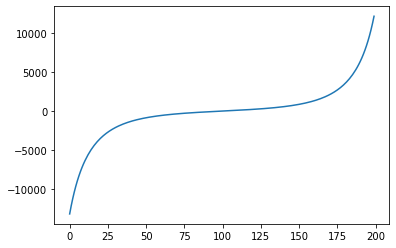

In [23]:
plt.plot(l)

In [17]:
x_d_r

(0.0036*e2*sin(e1)*cos(e1) - 0.07*e2 + 0.06*e4*(2.1924 - 0.4698*cos(e1)**2)*cos(e1) + 0.006*e4*cos(e1) + (0.0168 - 0.0036*cos(e1)**2)*(125.0*e1 + 30.78*e2) + 2.5*(0.00144*e2**2*sin(e1) + 0.006*e2*cos(e1) - 0.0024*e4 - 0.03528*sin(e1)*cos(e1))*cos(e1) - 0.4116*sin(e1))/(-6.1125*(0.001008 - 0.000216*cos(e1)**2)*cos(e1) + 0.006*cos(e1))